# Partición estratificada

Una técnica para manejar el desbalance de clases en problemas de clasificación supervisada, consiste en garantizar que todos los subconjuntos y grupos de datos tengan la misma proporción de desbalance de clase. De esta forma, no es necesario agregar ni eliminar ninguna columna. 

Para construir el modelo predictivo y reportar su desempeño usaremos particiones de la forma **Train - Validation - Test**. En donde los conjuntos tendrán los siguientes tamaños:

<img src="imgs/train-val-test.png" alt="Drawing" style="width: 600px;"/>

Debido al desbalance de clases, tanto el conjunto de test como el de train deben tener la misma proporción de desbalance de clase, que en nuestro caso es 0.21.

Adicionalmente, para evitar el sobreajuste y tener buena capacidad de generalización, en la calibración de hiperparámetros se implementa la técnica Stratified Kfold Cross Validation, que consiste en la partición de los conjuntos train y validation en grupos o folds que preservan la proporción de desbalance de clases.

<img src="imgs/skf.png" alt="Drawing" style="width: 600px;"/>

- EL XGBoost es un algoritmo de ensamble basado en árboles de decisión, es un algoritmo del estado del arte que han demostrado excelente desempeño en tareas de clasificación, además, dada su naturaleza de árobl de decisión, se trata de un modelo interpretable. Probaremos las diferentes ténicas para controlar el desbalance de clases mediante un XGboost cuyos hiperparámetros son ajustados usando GridSearch.

- La métrica principal de desempeño es el **f1-score**, ya que esta es el promedio armónico entre recall y precision, lo que significa que se brinda igual impoprtancia a la correcta clasificación de pagos e impagos. Esta es la métrica más adecuada en un contexto de desbalance de clase. 

## Librerías e importación de datos preprocesados

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

from utils import dar_estilo_visual, reporte_desempeno


In [12]:
dar_estilo_visual()
# Cargamos los datos preparados para la selección del modelo
df_modelo = pd.read_csv("cleaned_data/data_preparada.csv")

## Estructuración train - test estratificada

In [3]:
target = "default payment next month"
X = df_modelo.drop(columns=target)
y = df_modelo[target]

In [4]:
seed = 42
# Partición train-test preservando la proporción de impagos en cada parte
X_train, X_test, y_train, y_test= train_test_split(X, y, 
                                                    stratify=y, # Con este parámetro se garantiza la divisón estratificada
                                                    test_size=0.15, # 15% de registros destinados para test
                                                    shuffle=True,
                                                    random_state= seed)

In [5]:
# Validación de que se preserva la proporción de impagos
prop_train = len(y_train[y_train==1]) / len(y_train)
prop_test = len(y_test[y_test==1]) / len(y_test) 
print("Proporcion de impagos en el conjunto de entrenamiento: {:.2f}".format(prop_train))
print("Proporción de impagos en el conjunto de prueba (test): {:.2f}".format(prop_test))

Proporcion de impagos en el conjunto de entrenamiento: 0.21
Proporción de impagos en el conjunto de prueba (test): 0.21


In [6]:

skf = StratifiedKFold(n_splits=5, 
                      random_state=seed, 
                      shuffle=True)

In [7]:
xg_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100,500],
}

tuned_xgboost = GridSearchCV(XGBClassifier(), 
                             param_grid=xg_params, 
                             cv=skf, 
                             scoring="f1")
tuned_xgboost.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [100, 500]},
             scoring='f1')

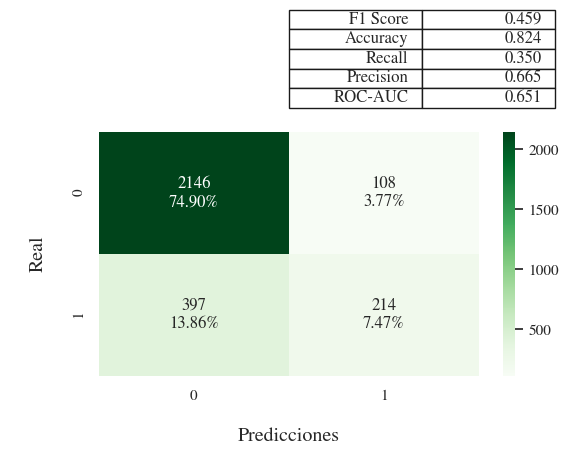

In [8]:
reporte_desempeno(y_test, tuned_xgboost.predict(X_test))

Podemos observar que el modelo no tiene un buen desempeño, pues las métricas f1 y recall se encuentras por debajo de 0.5, lo anterior se debe en gran parte al desbalance de clase, por lo tanto usaremos otras técnicas.

# Ovarsampling

El oversampling consiste en agregar filas con muestras de la clase menos favorecida al conjunto de entrenamiento, de tal forma que la proporción de clases negativas y positivas sea la misma.

En nuestro caso, usaremos una ténicnica llamada SMOTE  (Synthetic Minority Oversampling Technique) en la que se realiza la imputación de datos agregando varianza usando el algortimo KNN para crear la nueva data.

In [9]:
from imblearn.over_sampling import SMOTE

In [11]:
df_modelo

,Cupo_TC,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,...,PAGO_MES_t-1,PAGO_MES_t-2,PAGO_MES_t-3,PAGO_MES_t-4,PAGO_MES_t-5,default payment next month,AGE_DECILES,PROMEDIO_DEUDA,CUPO_DECILES,DEUDA/CUPO
0,80000,1,0,1,0,0,0,1,0,0,...,1740,1200,366,7432,0,0,10,29068.500000,3,0.363356
1,210000,1,0,0,1,0,0,0,1,0,...,5082,6000,5900,4544,4700,0,6,143074.666667,7,0.681308
2,230000,1,0,1,0,0,0,0,1,0,...,4987,6222,15121,17425,17007,0,9,18364.166667,7,0.079844
3,130000,1,0,0,0,1,0,0,1,0,...,4400,5000,4000,3500,4000,0,6,103045.666667,5,0.792659
4,470000,1,0,0,1,0,0,0,1,0,...,3000,3016,2200,3000,1600,0,6,60088.833333,10,0.127849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19090,280000,0,1,0,1,0,0,1,0,0,...,208141,5003,5002,5000,3000,0,9,122055.000000,8,0.435911
19091,180000,1,0,0,1,0,0,0,1,0,...,1300,7504,1123,13000,0,0,9,29093.166667,6,0.161629
19092,180000,0,1,0,1,0,0,0,1,0,...,1400,2200,0,0,0,0,6,26947.500000,6,0.149708
19093,320000,0,1,0,1,0,0,1,0,0,...,1224,739,742,751,703,0,4,28293.333333,9,0.088417


In [15]:
smote = SMOTE(random_state=seed)
X, y = smote.fit_resample(df_modelo.drop(columns=target), df_modelo[target])

In [16]:
X_train, X_test, y_train, y_test= train_test_split(X, y, 
                                                    test_size=0.15, # 15% de registros destinados para test
                                                    shuffle=True,
                                                    random_state= seed)

In [17]:
# Nueva proporción
prop_train = len(y_train[y_train==1]) / len(y_train)
prop_test = len(y_test[y_test==1]) / len(y_test) 
print("Proporcion de impagos en el conjunto de entrenamiento: {:.2f}".format(prop_train))
print("Proporción de impagos en el conjunto de prueba (test): {:.2f}".format(prop_test))

Proporcion de impagos en el conjunto de entrenamiento: 0.50
Proporción de impagos en el conjunto de prueba (test): 0.50


In [20]:
xg_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100,500],
}

tuned_xgboost = GridSearchCV(XGBClassifier(), 
                             param_grid=xg_params,  
                             cv=3,
                             scoring="f1")
tuned_xgboost.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...n=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [100, 500]},
             scoring='f1')

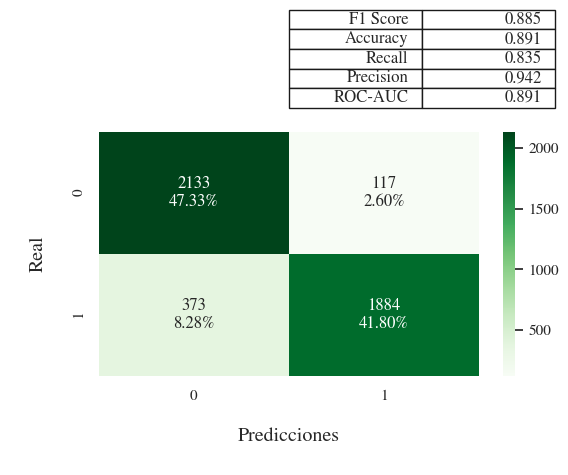

In [27]:
reporte_desempeno(y_test, tuned_xgboost.predict(X_test))

Observamos que al aplicar la técnica SMOTE de oversampling obtenemos resultados satisfactorios, con un Accuracy cercano al 90%, recall en 83% y F1-Score en 89%. Por lo tanto, es posible explicar los impagos del próximo mes mediante este modelo.